In [2]:
import torch
from torch import nn
import torch.nn.functional as F

from typing import Tuple, Union, List, Callable
from torch.optim import SGD
import torchvision
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [3]:
assert torch.cuda.is_available(), "GPU is not available, check the directions above (or disable this assertion to use CPU)"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)  # this should print out CUDA
# setting seed for reproduction
torch.manual_seed(546)

cuda


Processing data:
 * ToTensor: change value to 0 ~ 1
 * Normalize: change value to -1 to 1

In [4]:
transform = torchvision.transforms.Compose(
      [torchvision.transforms.ToTensor(), 
      torchvision.transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])]
  )
train_dataset = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Because I use batch_size as hyperparameter in the second model, so I let the data generation process to be a function.

In [5]:
def prepare_dataset(batch_size, train_dataset, test_dataset):
  train_dataset, val_dataset = random_split(train_dataset, [int(0.9 * len(train_dataset)), int( 0.1 * len(train_dataset))])

  # Create separate dataloaders for the train, test, and validation set
  train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True
  )

  val_loader = DataLoader(
      val_dataset,
      batch_size=batch_size,
      shuffle=True
  )

  test_loader = DataLoader(
      test_dataset,
      batch_size=batch_size,
      shuffle=True
  )
  return train_loader, val_loader, test_loader

## **First model:**

In [33]:
def linear_model(hidden_size) -> nn.Module:
  model = nn.Sequential(
      nn.Flatten(),   # batch_size * 3 * 32 * 32 to batch_size * 3072
      nn.Linear(3072, hidden_size), # 3072 -> hidden_size
      nn.ReLU(),
      nn.Linear(hidden_size, 10)    # hidden_size -> 10
  )
  return model.to(DEVICE)

In [14]:
def train(
    model: nn.Module, optimizer: SGD, 
    train_loader: DataLoader, val_loader: DataLoader, 
    batch_size: int, epochs: int = 20
    ) -> Tuple[List[float], List[float], List[float], List[float]]:

    loss = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for _ in range(epochs):
      model.train()
      train_loss = 0.0
      train_acc = 0.0

      for (x_batch, labels) in train_loader:
        x_batch, labels = x_batch.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        labels_pred = model(x_batch)
        batch_loss = loss(labels_pred, labels)
        train_loss += batch_loss.item()

        labels_pred_max = torch.argmax(labels_pred, 1) # choose the highest index from row
        batch_acc = torch.sum(labels_pred_max == labels)
        train_acc += batch_acc.item()

        batch_loss.backward()
        optimizer.step()

      train_losses.append(train_loss / len(train_loader))
      train_accuracies.append(train_acc / (batch_size * len(train_loader)))

      # validation process
      model.eval()
      val_loss = 0.0
      val_acc = 0.0

      with torch.no_grad():  # to save the memory
        for (v_batch, labels) in val_loader:
          v_batch, labels = v_batch.to(DEVICE), labels.to(DEVICE)
          labels_pred = model(v_batch)
          v_batch_loss = loss(labels_pred, labels)
          val_loss = val_loss + v_batch_loss.item()

          v_pred_max = torch.argmax(labels_pred, 1)
          batch_acc = torch.sum(v_pred_max == labels)
          val_acc = val_acc + batch_acc.item()
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc / (batch_size * len(val_loader)))

    return train_losses, train_accuracies, val_losses, val_accuracies


Using learning rate and hidden size as hyperparameter

In [15]:
def parameter_search_a(train_dataset, test_dataset, model_fn:Callable[[], nn.Module]) -> float:
  # find best learning rate for SGD optimizer
  # find best hidden_size for model
  best_loss = torch.inf
  best_lr = 0.0
  best_h = 0

  lrs = [0.01, 0.001, 0.0001]
  hidden_size = [30, 60, 90]
  loss_dict = {}
  loss_list = [] # store the min(loss) and its configuration
  acc_dict = {}

  for lr in lrs:
    for h in hidden_size:
      print(f"trying learning rate {lr} and hidden_size as {h}")
      train_loader, val_loader, test_loader = prepare_dataset(128, train_dataset, test_dataset)
      model = model_fn(h)
      optim = SGD(model.parameters(), lr)

      train_loss, train_acc, val_loss, val_acc = train(
          model,
          optim,
          train_loader,
          val_loader,
          128, 
          epochs=30
          )
      loss_dict[f"{lr}+{h}"] = {"train": train_loss, "val": val_loss}
      loss_list.append([min(val_loss), f"{lr}+{h}"])
      acc_dict[f"{lr}+{h}"] = {"train": train_acc, "val": val_acc}
      
      if min(val_loss) < best_loss:
        best_loss = min(val_loss)
        best_lr = lr
        best_h = h

  return best_lr, best_h, loss_dict, sorted(loss_list), acc_dict

In [ ]:

best_lr, best_h, d1_loss, l1_loss, d1_acc = parameter_search_a(train_dataset, test_dataset, linear_model)

trying learning rate 0.01 and hidden_size as 30
trying learning rate 0.01 and hidden_size as 60
trying learning rate 0.01 and hidden_size as 90
trying learning rate 0.001 and hidden_size as 30
trying learning rate 0.001 and hidden_size as 60
trying learning rate 0.001 and hidden_size as 90
trying learning rate 0.0001 and hidden_size as 30
trying learning rate 0.0001 and hidden_size as 60
trying learning rate 0.0001 and hidden_size as 90


Print the loss and its configuration to know which model is good.

In [ ]:
print(best_lr, best_h)

0.01 90


In [ ]:
print(l1_loss)

[[1.3895368620753288, '0.01+90'], [1.4337662398815154, '0.01+30'], [1.4413400053977967, '0.01+60'], [1.651184993982315, '0.001+90'], [1.667005005478859, '0.001+60'], [1.6734070301055908, '0.001+30'], [2.009666898846626, '0.0001+30'], [2.011662554740906, '0.0001+90'], [2.0227504581213, '0.0001+60']]


Plot for quesiton (a)

In [ ]:
print(d1_acc["0.01+90"]["val"])

[0.341015625, 0.375390625, 0.3931640625, 0.40234375, 0.4130859375, 0.423046875, 0.4310546875, 0.4400390625, 0.446484375, 0.446484375, 0.4541015625, 0.4580078125, 0.459375, 0.463671875, 0.46875, 0.466015625, 0.466015625, 0.471484375, 0.47734375, 0.4791015625, 0.4798828125, 0.480859375, 0.4828125, 0.4837890625, 0.4853515625, 0.486328125, 0.4837890625, 0.4896484375, 0.4890625, 0.492578125, 0.49453125, 0.4939453125, 0.4908203125, 0.492578125, 0.4998046875, 0.5001953125, 0.4953125, 0.494140625, 0.495703125, 0.49921875]


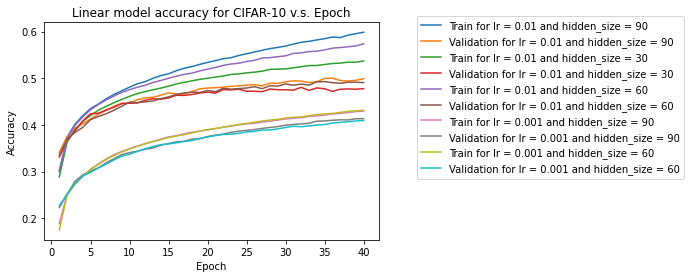

In [ ]:
epochs = range(1, 31)
plt.figure()
plt.plot(epochs, d1_acc["0.01+90"]["train"], label = "Train for lr = 0.01 and hidden_size = 90")
plt.plot(epochs, d1_acc["0.01+90"]["val"], label = "Validation for lr = 0.01 and hidden_size = 90")
plt.plot(epochs, d1_acc["0.01+30"]["train"], label = "Train for lr = 0.01 and hidden_size = 30")
plt.plot(epochs, d1_acc["0.01+30"]["val"], label = "Validation for lr = 0.01 and hidden_size = 30")
plt.plot(epochs, d1_acc["0.01+60"]["train"], label = "Train for lr = 0.01 and hidden_size = 60")
plt.plot(epochs, d1_acc["0.01+60"]["val"], label = "Validation for lr = 0.01 and hidden_size = 60")
plt.plot(epochs, d1_acc["0.001+90"]["train"], label = "Train for lr = 0.001 and hidden_size = 90")
plt.plot(epochs, d1_acc["0.001+90"]["val"], label = "Validation for lr = 0.001 and hidden_size = 90")
plt.plot(epochs, d1_acc["0.001+60"]["train"], label = "Train for lr = 0.001 and hidden_size = 60")
plt.plot(epochs, d1_acc["0.001+60"]["val"], label = "Validation for lr = 0.001 and hidden_size = 60")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Linear model accuracy for CIFAR-10 v.s. Epoch")
plt.show()

In [35]:

train_loader, val_loader, test_loader = prepare_dataset(128, train_dataset, test_dataset)
model = linear_model(90)
optim = SGD(model.parameters(), 0.01)

train_loss, train_acc, val_loss, val_acc = train(model,optim,train_loader,val_loader, 128,epochs=50)

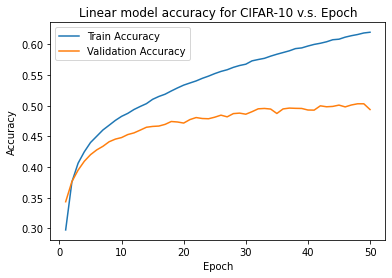

In [9]:
epochs = range(1, 51)
plt.figure()
plt.plot(epochs, train_acc, label = "Train Accuracy")
plt.plot(epochs, val_acc, label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Linear model accuracy for CIFAR-10 v.s. Epoch")
plt.show()

In [10]:
print(val_acc)

[0.3435546875, 0.3763671875, 0.3951171875, 0.4095703125, 0.4203125, 0.428125, 0.433984375, 0.44140625, 0.445703125, 0.4482421875, 0.453125, 0.455859375, 0.4603515625, 0.4650390625, 0.46640625, 0.4669921875, 0.4697265625, 0.4744140625, 0.4736328125, 0.471875, 0.4775390625, 0.480859375, 0.479296875, 0.47890625, 0.4814453125, 0.484765625, 0.48203125, 0.4873046875, 0.4880859375, 0.486328125, 0.4904296875, 0.4951171875, 0.495703125, 0.4947265625, 0.4875, 0.494921875, 0.4962890625, 0.4958984375, 0.495703125, 0.4931640625, 0.49296875, 0.5, 0.4984375, 0.4990234375, 0.501171875, 0.4982421875, 0.5013671875, 0.5033203125, 0.5033203125, 0.4939453125]


In [16]:
print(val_acc[44]) # the first epoch that over 50% accuracy

0.501171875


In [30]:
def evaluate(
    model: nn.Module, loader: DataLoader, batch_size: int
) -> Tuple[float, float]:
  """Computes test loss and accuracy of model on loader."""
  loss = nn.CrossEntropyLoss()
  model.eval()
  test_loss = 0.0
  test_acc = 0.0
  with torch.no_grad():
    for (batch, labels) in loader:
      batch, labels = batch.to(DEVICE), labels.to(DEVICE)
      y_batch_pred = model(batch)
      batch_loss = loss(y_batch_pred, labels)
      test_loss = test_loss + batch_loss.item()

      pred_max = torch.argmax(y_batch_pred, 1)
      batch_acc = torch.sum(pred_max == labels)
      test_acc = test_acc + batch_acc.item()
    test_loss = test_loss / len(loader)
    test_acc = test_acc / (batch_size * len(loader))
    return test_loss, test_acc

Calculate the test_dataset accuracy:

In [36]:

test_loss, test_acc = evaluate(model, test_loader, 128)
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.5136471518987342


# **Second model:**

Model defining (using all the reasoning choose)

In [8]:
def conv_model():
  model = nn.Sequential(
      nn.Conv2d(3, 100, 5),  # 128 * 3 * 32 * 32. to 128 * 3 * (33 - 5) * 27 (33? is this a typo?)
      nn.ReLU(), 
      nn.MaxPool2d(2, 2),                      # 128 * 3 * 28 * 28 to 128 * 3 * 14 * 14
      nn.Flatten(), 
      nn.Linear(100 * 14 * 14, 10)   # 128 * 3 * 2 * 2 to 128 * 3 * 10 
  )
  return model.to(DEVICE)

Use learning rate and batch_size as hyperparameter

In [16]:
def parameter_search_b(train_dataset, test_dataset, model_fn:Callable[[], nn.Module]) -> float:
  
  best_loss = torch.inf
  best_lr = 0.0
  best_batch = 0
  loss_dict = {}
  loss_list = []
  acc_dict = {}

  lrs = [0.1, 0.01, 0.001]
  batchs = [64, 128, 256]

  for lr in lrs:
    for batch in batchs:
      print(f"trying learning rate {lr} and batch_size {batch}.")
      # batch_size = batch
      train_loader, val_loader, test_loader = prepare_dataset(batch, train_dataset, test_dataset)

      model = model_fn()
      optim = SGD(model.parameters(), lr)

      train_loss, train_acc, val_loss, val_acc = train(
          model,
          optim,
          train_loader,
          val_loader,
          batch, 
          epochs=30
          )
      loss_dict[f"{lr}+{batch}"] = {"train": train_loss, "val": val_loss}
      loss_list.append([min(val_loss), f"{lr}+{batch}"])
      acc_dict[f"{lr}+{batch}"] = {"train": train_acc, "val": val_acc}

      if min(val_loss) < best_loss:
        best_loss = min(val_loss)
        best_lr = lr
        best_batch = batch

  return best_lr, best_batch, loss_dict, sorted(loss_list), acc_dict

In [17]:
 
best_l, best_batch, d2_loss, l2_loss, d2_acc = parameter_search_b(train_dataset, test_dataset, conv_model)

trying learning rate 0.1 and batch_size 64.
trying learning rate 0.1 and batch_size 128.
trying learning rate 0.1 and batch_size 256.
trying learning rate 0.01 and batch_size 64.
trying learning rate 0.01 and batch_size 128.
trying learning rate 0.01 and batch_size 256.
trying learning rate 0.001 and batch_size 64.
trying learning rate 0.001 and batch_size 128.
trying learning rate 0.001 and batch_size 256.


Print the result:

In [18]:
print(best_l, best_batch)

0.1 256


In [28]:
print(d2_acc["0.1+256"]["val"])

[0.501171875, 0.5376953125, 0.5224609375, 0.6015625, 0.62734375, 0.603515625, 0.6384765625, 0.6236328125, 0.6302734375, 0.59375, 0.6525390625, 0.6423828125, 0.6498046875, 0.633984375, 0.665625, 0.640625, 0.65390625, 0.6234375, 0.6599609375, 0.6611328125, 0.6509765625, 0.64609375, 0.6390625, 0.6345703125, 0.6455078125, 0.646875, 0.6625, 0.6390625, 0.6412109375, 0.657421875]


In [26]:
print(l2_loss[:5])

[[0.9522730767726898, '0.1+256'], [0.9727176189422607, '0.01+128'], [0.9915038196346427, '0.01+64'], [1.0515513755381107, '0.1+128'], [1.0696197688579558, '0.01+256']]


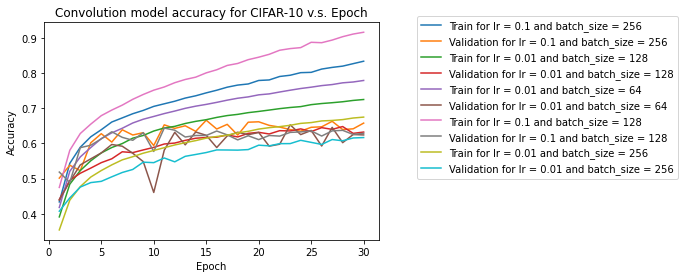

In [40]:
epochs = range(1, 31)
plt.figure()
plt.plot(epochs, d2_acc["0.1+256"]["train"], label = "Train for lr = 0.1 and batch_size = 256")
plt.plot(epochs, d2_acc["0.1+256"]["val"], label = "Validation for lr = 0.1 and batch_size = 256")
plt.plot(epochs, d2_acc["0.01+128"]["train"], label = "Train for lr = 0.01 and batch_size = 128")
plt.plot(epochs, d2_acc["0.01+128"]["val"], label = "Validation for lr = 0.01 and batch_size = 128")
plt.plot(epochs, d2_acc["0.01+64"]["train"], label = "Train for lr = 0.01 and batch_size = 64")
plt.plot(epochs, d2_acc["0.01+64"]["val"], label = "Validation for lr = 0.01 and batch_size = 64")
plt.plot(epochs, d2_acc["0.1+128"]["train"], label = "Train for lr = 0.1 and batch_size = 128")
plt.plot(epochs, d2_acc["0.1+128"]["val"], label = "Validation for lr = 0.1 and batch_size = 128")
plt.plot(epochs, d2_acc["0.01+256"]["train"], label = "Train for lr = 0.01 and batch_size = 256")
plt.plot(epochs, d2_acc["0.01+256"]["val"], label = "Validation for lr = 0.01 and batch_size = 256")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Convolution model accuracy for CIFAR-10 v.s. Epoch")
plt.show()

In [37]:
model = conv_model()
optim = SGD(model.parameters(), best_l)
train_loader, val_loader, test_loader = prepare_dataset(256, train_dataset, test_dataset)
train_loss, train_acc, val_loss, val_acc = train(model,optim,train_loader,val_loader,  256,epochs=30)
print(val_acc)

[0.4529296875, 0.522265625, 0.5802734375, 0.572265625, 0.5892578125, 0.62421875, 0.6103515625, 0.6275390625, 0.6279296875, 0.61796875, 0.61015625, 0.651171875, 0.63984375, 0.642578125, 0.622265625, 0.6158203125, 0.621484375, 0.642578125, 0.6474609375, 0.560546875, 0.628515625, 0.62265625, 0.637109375, 0.6501953125, 0.648046875, 0.6439453125, 0.6546875, 0.6298828125, 0.6486328125, 0.645703125]


In [22]:
print(val_acc[21])

0.653125


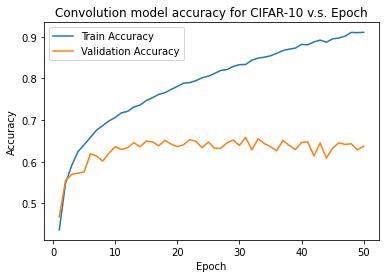

In [23]:
epochs = range(1, 51)
plt.figure()
plt.plot(epochs, train_acc, label = "Train Accuracy")
plt.plot(epochs, val_acc, label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Convolution model accuracy for CIFAR-10 v.s. Epoch")
plt.show()

In [39]:
test_loss, test_acc = evaluate(model, test_loader, 256)
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.65029296875
